# Single Stock Demo

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import (
    process_leveraged_data, 
    leverage_dataframe,
    find_ath_indices, 
    calculate_ath_returns_all_periods, 
    calculate_non_ath_returns_all_periods,
    plot_returns
)

## Simple Implementation - *Easy-to-understand version for those who only care about the results.*

### Simulating Leveraged Adjusted Close Prices

The code loads and processes simulated leveraged adjusted close prices for a given equity. Here's a breakdown:
- The function `simulate_data.process_leveraged_data()` downloads historical price data for a specified ticker (e.g., "SPY") and uses a leverage scalar (e.g., 3) to determine the multiplier for leveraged returns.
- The function calculates daily percentage returns (`Daily Return`) from the adjusted close prices.
- Leveraged returns are simulated by multiplying the daily returns by the specified leverage scalar.
- These leveraged returns are then compounded to simulate the cumulative leveraged price (`Simulated Leveraged Price`).

In [47]:
data = process_leveraged_data(tickers='SPY', leverage_scalars=3)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,Leveraged Return,Simulated Leveraged Price
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,24.526085,1003200,NaN,0.000000,24.526085
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,24.700510,480500,0.007112,0.021335,25.049360
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,24.752850,201300,0.002119,0.006357,25.208597
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.014521,529400,0.010571,0.031714,26.008063
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,25.119156,531500,0.004183,0.012549,26.334437


### Plotting The Returns of Simulated Leveraged Portfolio Data  
The `plot_returns` function uses the data generated from process_leveraged_data to analyze and visualize forward returns during All-Time High (ATH) and Non-ATH or Non-52-week high and 52-week high periods across different time windows, allowing you to <ins>assess how the portfolio performs when buying close to an ATH or 52-week high versus not</ins>. 

#### Key Features:
- **Window Periods** (`windows=`): You can specify a list of window sizes (e.g., [5, 10, 20]), where each window defines the range of days before and after an ATH event that is included in the analysis. For instance, a window size of 5 includes data from 5 days before and after the ATH date.
- **Custom Price Column** (`price_column=`): By default, the analysis uses the TotalPortfolioPrice column, but you can specify a different column to track price changes, allowing flexibility in the analysis.
- **Type of High** (`high_type=`): High type is set to 'ATH' for all-time high by default; however, you have the option to set the high type to be '52W' for 52-week high. 'ATH' grabs the indice(s) +- window size for each unique all time high price. '52W' grabs the indice(s) +- window size for each unique 52 week high in price.
- **Custom Holding Periods** (`holding_periods=`): A dictionary where keys represent holding period labels (e.g., 'Return_3M') and values are the number of days in each holding period (e.g., 91 for 3 months). This parameter allows full control over the timeframes used for return calculations.
- **Compare Leveraged vs. Unleveraged Returns** (`plot_relative`): Plots side-by-side charts for leveraged and unleveraged performance using the same unleveraged high-point buy strategy (i.e. the leveraged and unleveraged have differnt purchase timings).


#### What it does:
- For each window, the function identifies ATH or 52-week high indices, which essentially tell us that if you are to buy within the defined days before, after, or on an ATH or 52-week high, you can expect the following forward-looking returns.
- The returns are then visualized using a boxplot that compares the return distributions across multiple holding periods (e.g., 3M, 6M, 12M, 24M, 48M).

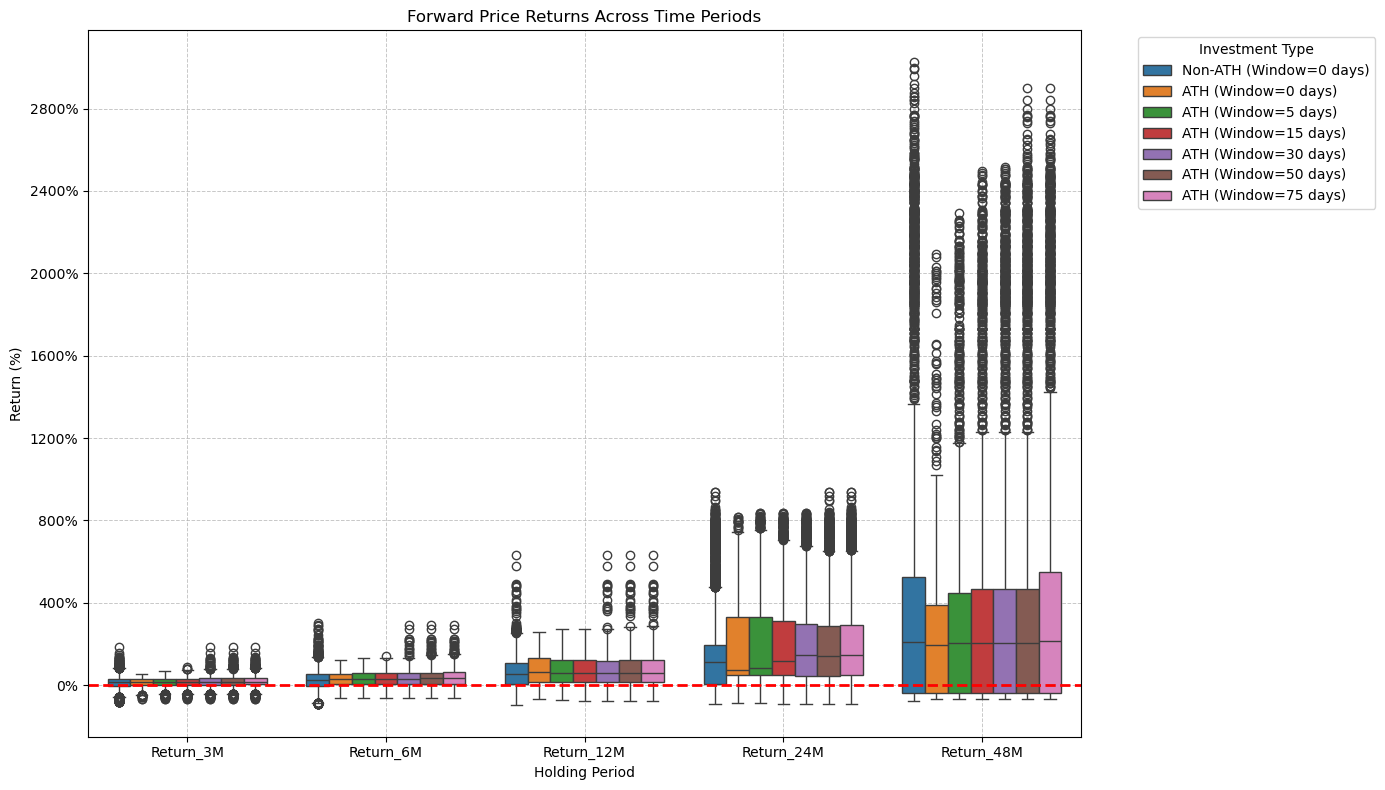

In [48]:
# Visualizing All Time High returns 
plot_returns(data, windows=[0, 5, 15, 30, 50, 75], price_column='Simulated Leveraged Price', high_type="ATH")

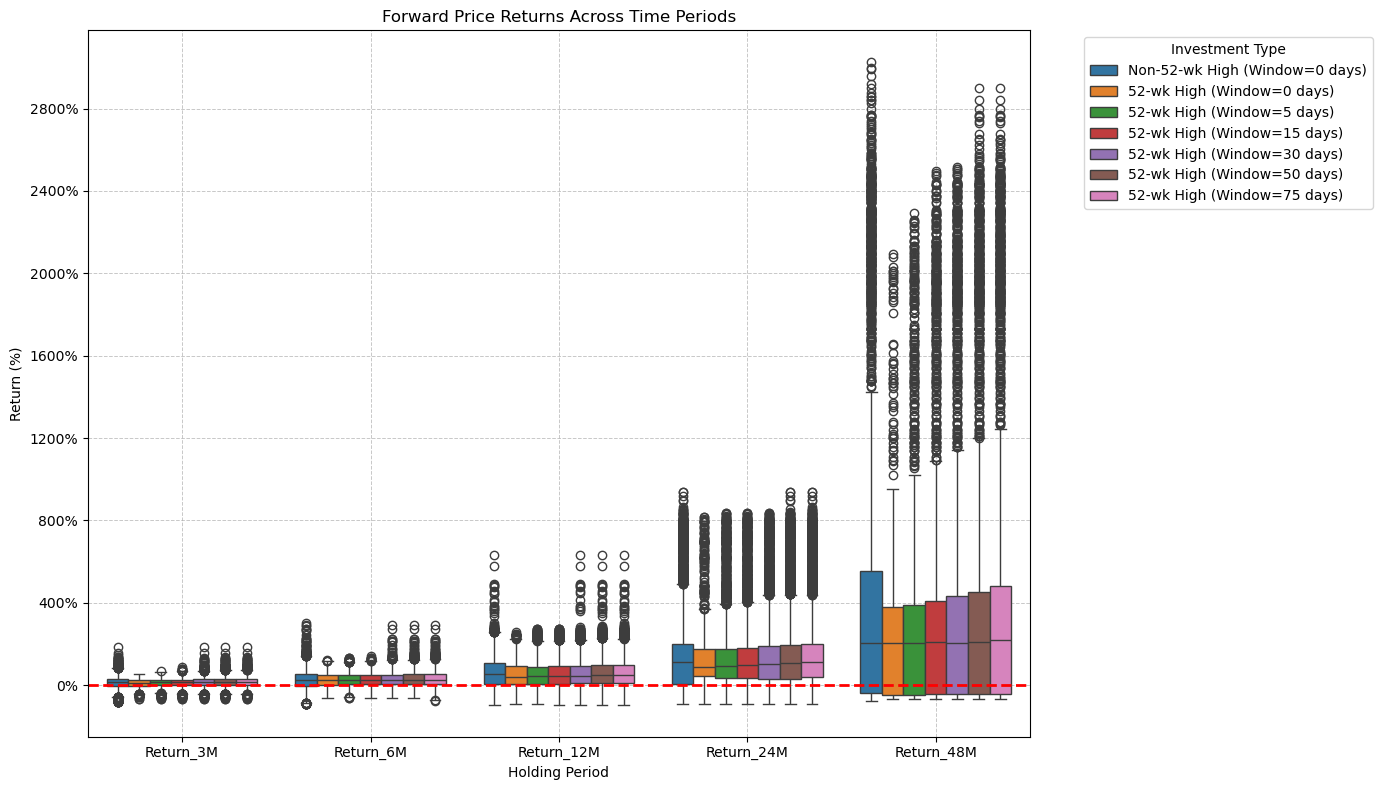

In [49]:
# Visualizing 52 Week High returns 
plot_returns(data, windows=[0, 5, 15, 30, 50, 75], price_column='Simulated Leveraged Price', high_type="52W")

We can visualize the All Time High returns when using leverage vs. using no leverage by doing the following:


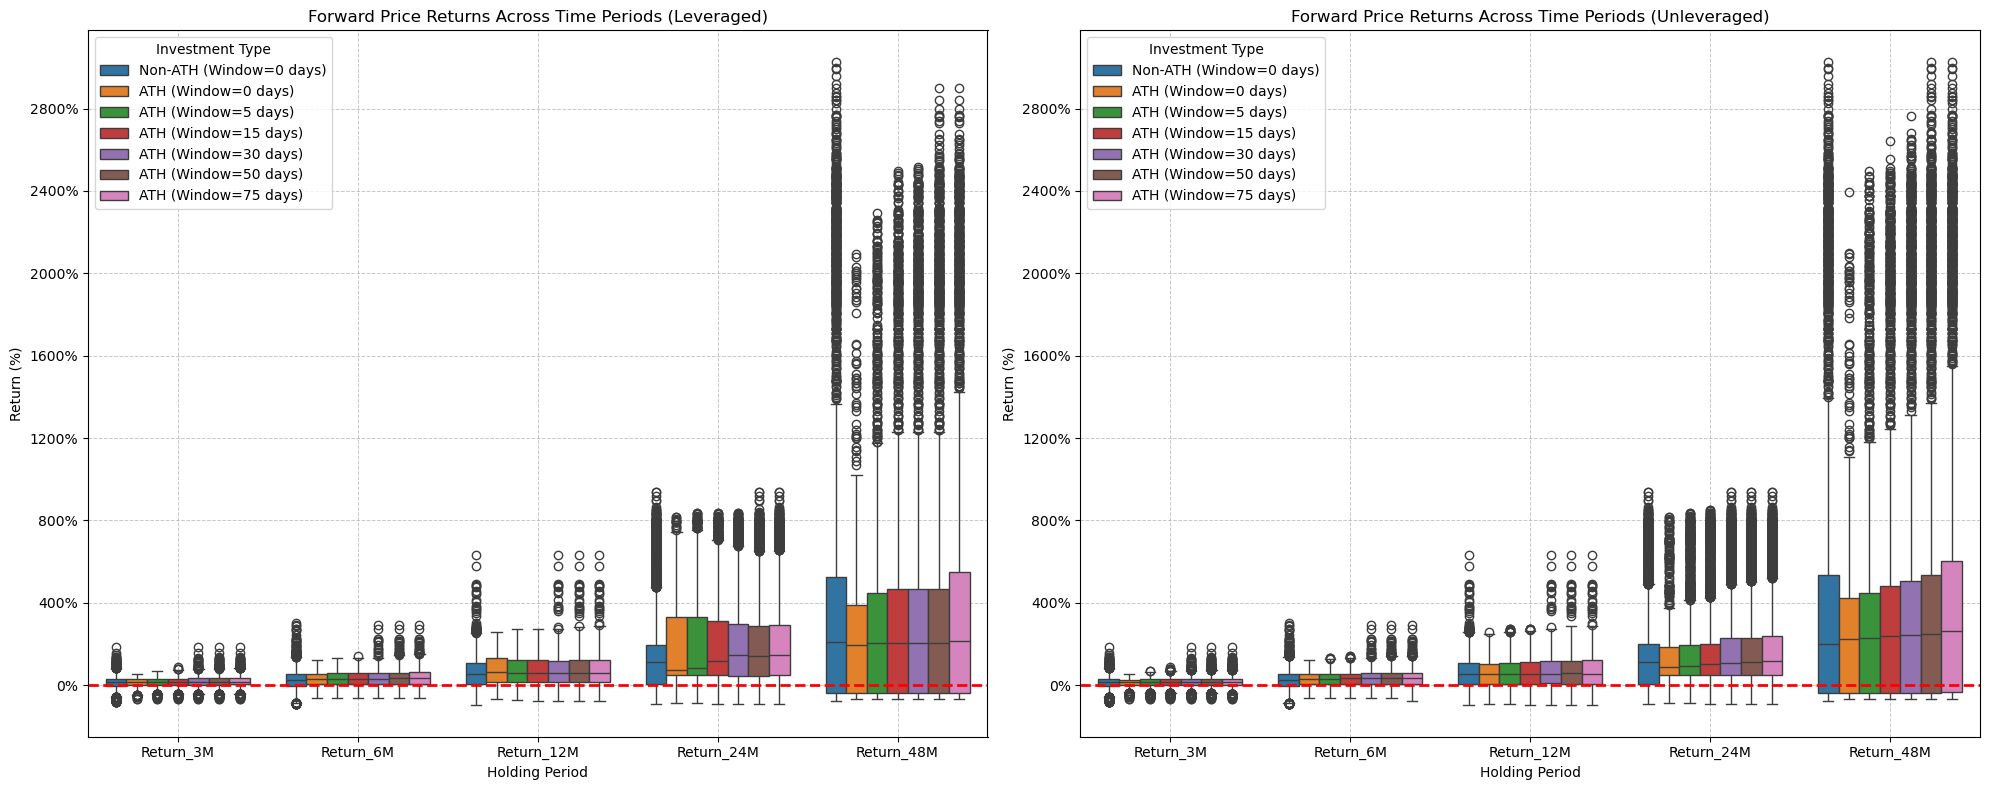

In [50]:
# Passing plot_relative as True
plot_returns(data, windows=[0, 5, 15, 30, 50, 75], price_column='Simulated Leveraged Price', plot_relative=True) 

The return spread appears quite similar. To focus on our desired holding period (e.g., 1-2 years), we can take a closer look by doing the following:

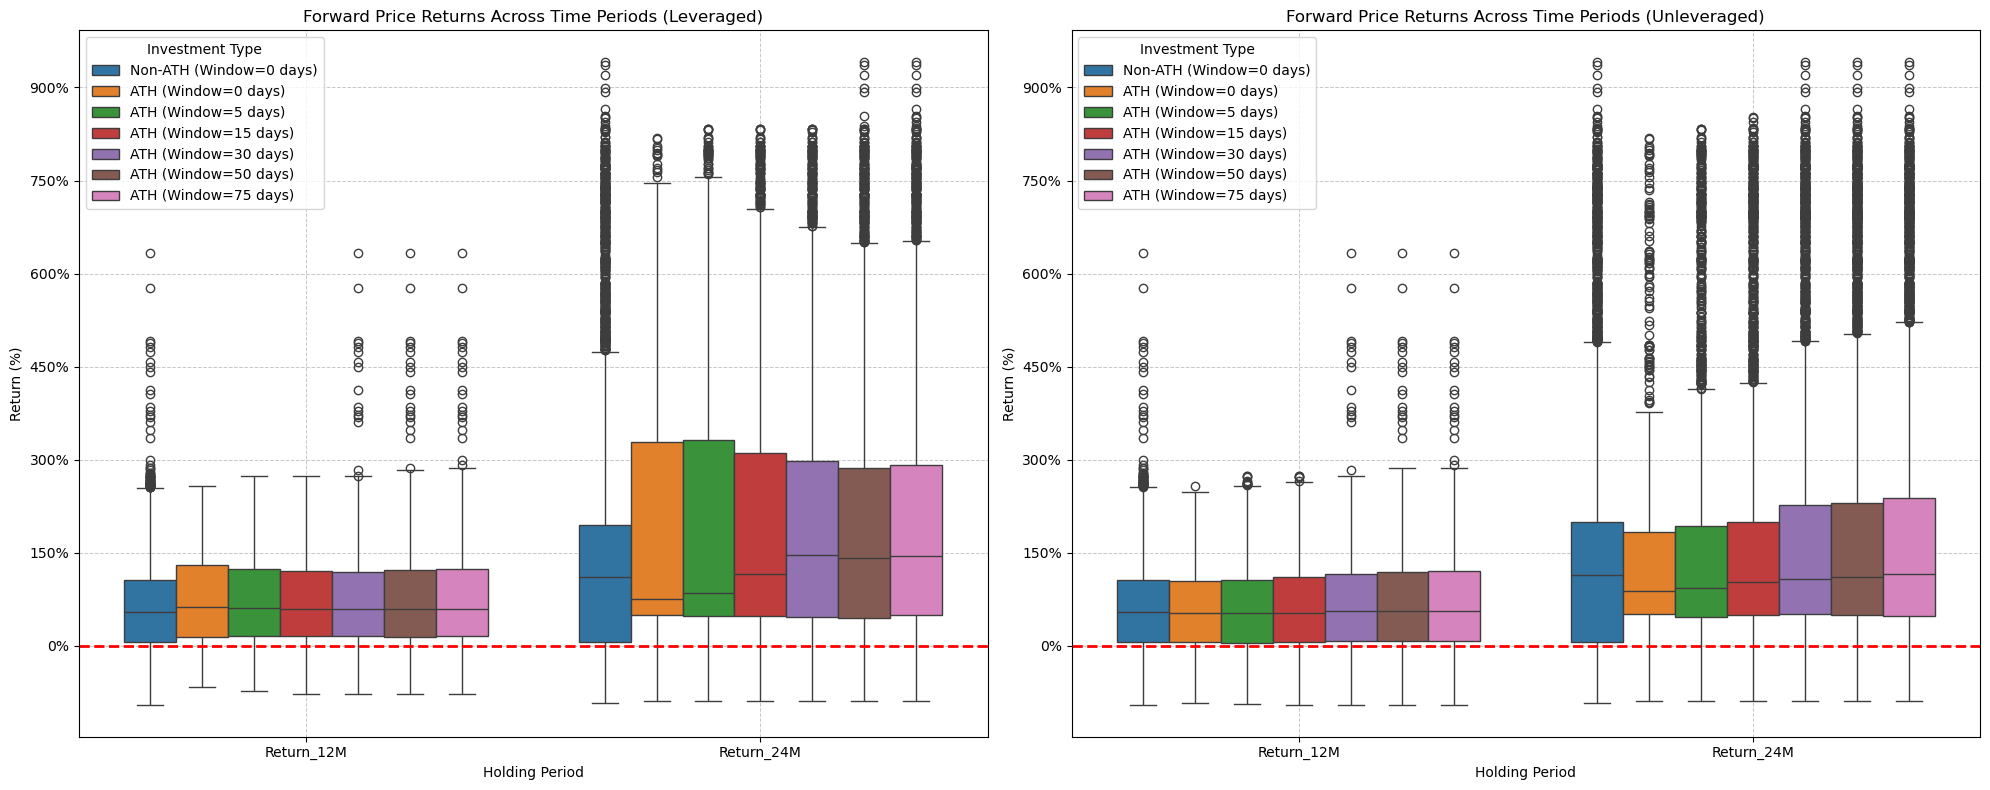

In [51]:
# Passing holding_periods w/ a dict of the desired holding ranges (counts in days)
plot_returns(data, windows=[0, 5, 15, 30, 50, 75], price_column='Simulated Leveraged Price', plot_relative=True, holding_periods={'Return_12M': 365,'Return_24M': 730})

## Alternatively, Users Can Load Their Own Data to See How Leverage Affects It
For example, we can load in Shiller Data, which provides historical large-cap U.S. stock market returns, including data from the S&P and other sources, dating back to the 1800s. [Shiller Data Linked Here](http://www.econ.yale.edu/~shiller/data.htm)

In [53]:
# Since we are manually loading in the data we will have to clean it up a little. 
data = pd.read_excel('ie_data.xls', sheet_name='Data') 
data = data.iloc[7:,[0,7]]
data.columns = ['Date', 'Adj Close'] # price column MUST BE NAMED 'Adj Close'. A date column is not required.  
data = data.reset_index(drop=True) # leverage_dataframe() calculates values based on indices, so ensure that indices properly range from 0 to n.
data.head() 

,Date,Adj Close
0,1871.01,112.34055
1,1871.02,110.485092
2,1871.03,111.533152
3,1871.04,119.022371
4,1871.05,124.873408


After cleaning our data, we can call the `leverage_dataframe()` function. We pass the cleaned data as the first parameter and the leverage scalar to set the multiplier for leveraged returns.

In [67]:
# Calling leverage_dataframe(), note that this is a different function than process_leveraged_data()
leveraged_data = leverage_dataframe(data, 3)
leveraged_data

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,Leveraged Return,Simulated Leveraged Price,Leveraged Price
0,1999-03-10,51.125000,51.156250,50.281250,51.062500,43.347397,5232000,NaN,0.000000,43.347397,43.347397
1,1999-03-11,51.437500,51.734375,50.312500,51.312500,43.559605,9688600,0.004896,0.014687,43.984020,43.984020
2,1999-03-12,51.125000,51.156250,49.656250,50.062500,42.498474,8743600,-0.024360,-0.073081,40.769612,40.769612
3,1999-03-15,50.437500,51.562500,49.906250,51.500000,43.718796,6369000,0.028714,0.086143,44.281647,44.281647
4,1999-03-16,51.718750,52.156250,51.156250,51.937500,44.090176,4905800,0.008495,0.025484,45.410130,45.410130
...,...,...,...,...,...,...,...,...,...,...,...
6505,2025-01-16,518.979980,519.059998,512.950012,513.080017,513.080017,28229000,-0.007006,-0.021018,230.684472,230.684472
6506,2025-01-17,522.849976,524.070007,513.109985,521.739990,521.739990,51837900,0.016878,0.050635,242.365231,242.365231
6507,2025-01-21,524.479980,525.969971,520.059998,524.799988,524.799988,23628000,0.005865,0.017595,246.629636,246.629636
6508,2025-01-22,529.570007,533.820007,529.260010,531.510010,531.510010,33593000,0.012786,0.038358,256.089756,256.089756


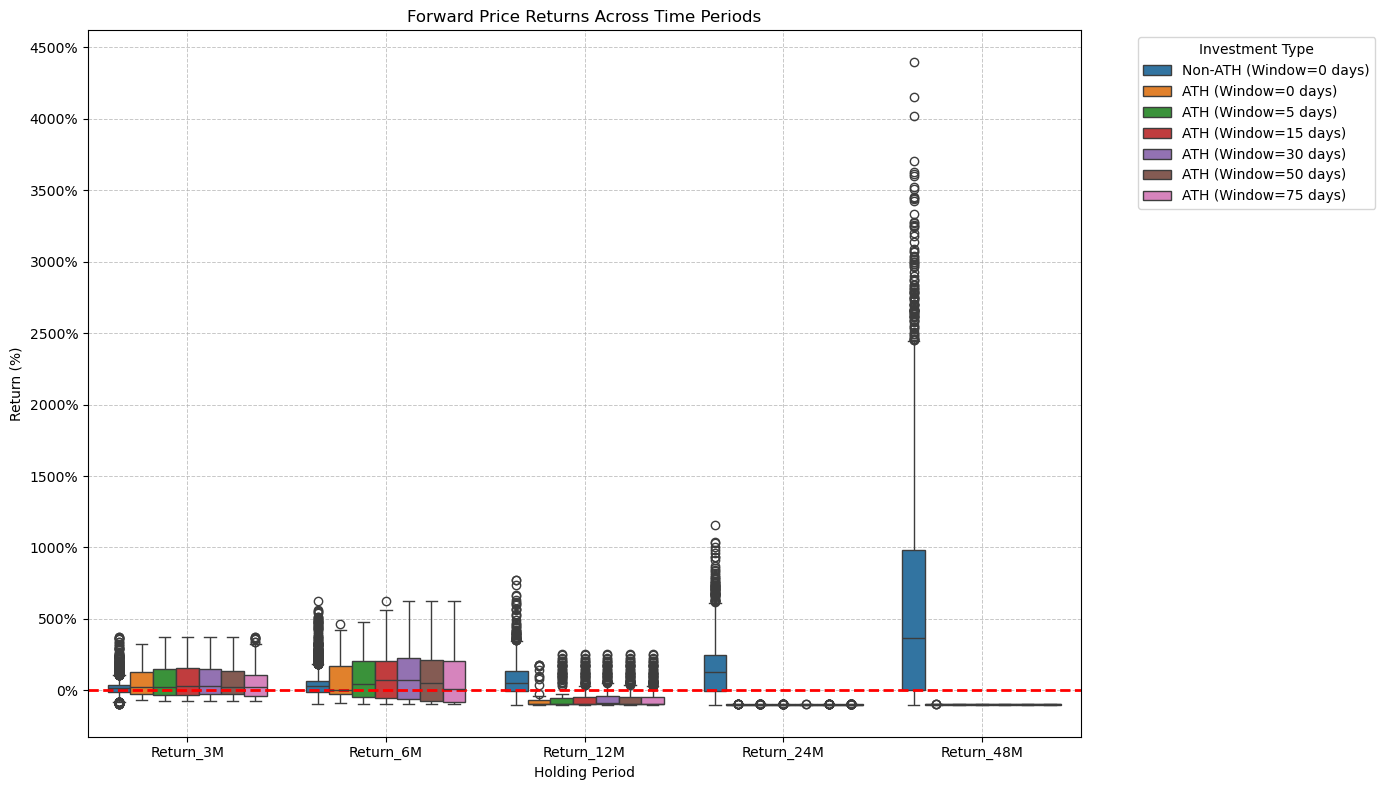

In [68]:
# Visualizing All Time High returns 
plot_returns(data, windows=[0, 5, 15, 30, 50, 75], price_column='Leveraged Price', high_type="ATH")

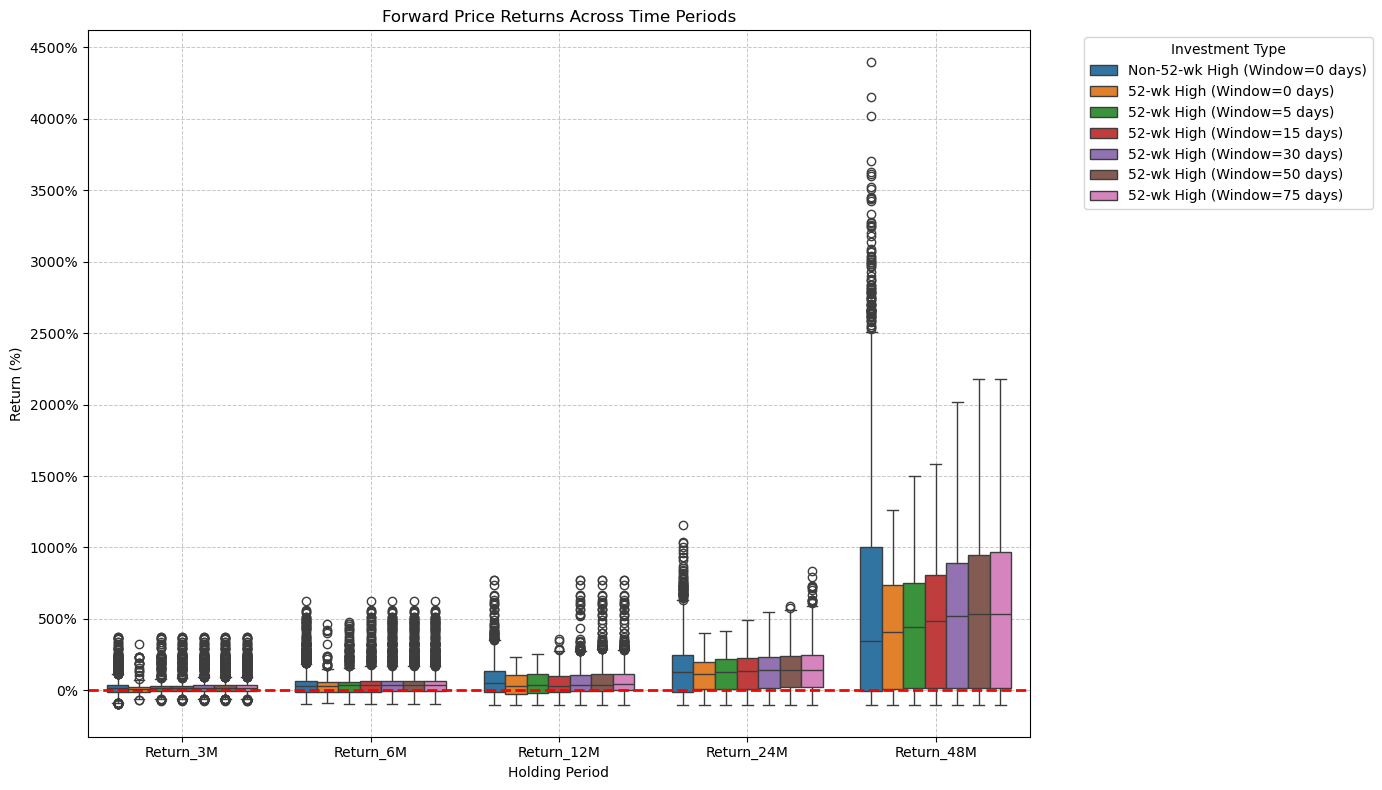

In [69]:
# Visualizing 52 Week High returns 
plot_returns(data, windows=[0, 5, 15, 30, 50, 75], price_column='Leveraged Price', high_type="52W")

When backtesting with Shiller data, we observe that purchasing at or near all-time highs performs very poorly, while investing at or near 52-week highs yields much better results. Let’s take a closer look at how leveraged versus unleveraged Shiller data performs durring 1 to 2 years.

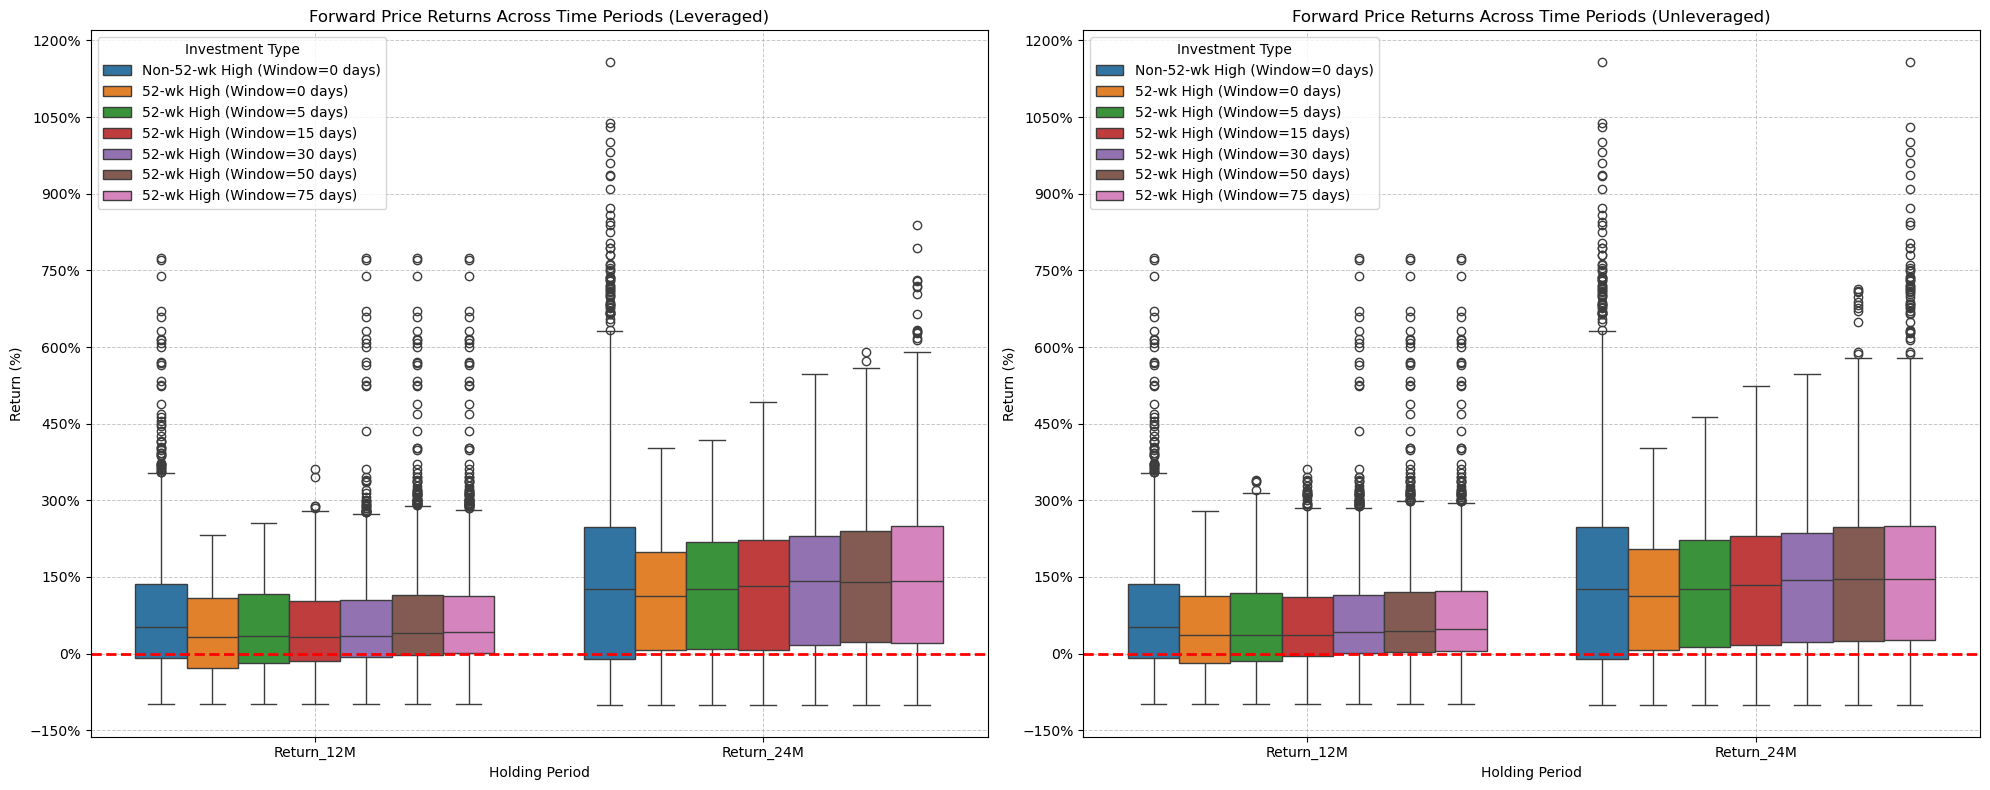

In [76]:
plot_returns(data, windows=[0, 5, 15, 30, 50, 75], price_column='Leveraged Price', high_type="52W", plot_relative=True, holding_periods={'Return_12M': 365,'Return_24M': 730}) 

## Detailed Implementation - *For those who want to play with some calculations and explore the inner workings.*

Once again we call `simulate_data.process_leveraged_data()`. If you're interested in the inner workings of this function, feel free to explore its definition in `utilities.py`.

In [59]:
# Load in the desired ticker 
data = process_leveraged_data(tickers='QQQ', leverage_scalars=3)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,Leveraged Return,Simulated Leveraged Price
0,1999-03-10,51.12500,51.156250,50.28125,51.0625,43.347397,5232000,NaN,0.000000,43.347397
1,1999-03-11,51.43750,51.734375,50.31250,51.3125,43.559605,9688600,0.004896,0.014687,43.984020
2,1999-03-12,51.12500,51.156250,49.65625,50.0625,42.498474,8743600,-0.024360,-0.073081,40.769612
3,1999-03-15,50.43750,51.562500,49.90625,51.5000,43.718796,6369000,0.028714,0.086143,44.281647
4,1999-03-16,51.71875,52.156250,51.15625,51.9375,44.090176,4905800,0.008495,0.025484,45.410130


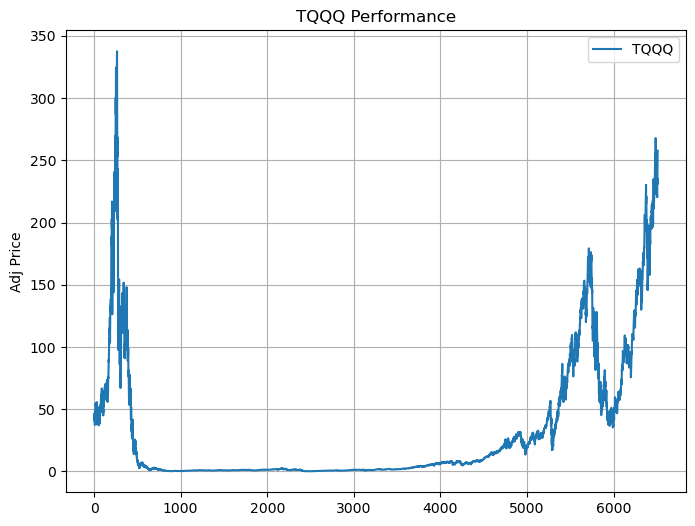

In [60]:
# Graphing the Cumulative returns of the ETF's and splits in question
plt.figure(figsize=(8, 6))
plt.plot(data['Simulated Leveraged Price'], label='TQQQ')
plt.legend()
plt.title('TQQQ Performance')
plt.ylabel('Adj Price')
plt.grid(True)
plt.show()

### Identifying Indices of All-Time Highs

This code identifies the indices where the adjusted close price and the simulated leveraged price reach new all-time highs to be used later in analysis.   
  
*Note that A window defines the range of days before and after an event that we're including in our analysis. For example, if the window is set to 5, it means we are looking at data within 5 days before and after a specific All Time High date.*

In [61]:
def find_ath_indices(data, column, window=0):
    """
    Find indices where the column reaches a new all-time high and optionally expand indices by window of days.
    
    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to evaluate for all-time highs.
        Similarly, as mentioned above, we can examine the spread across multiple windows. (int): Number of days to expand the indices by (± window). Default is 0.
    
    Returns:
        list: List of indices where a new all-time high is set, optionally expanded.
    """
    ath_indices = []
    current_ath = -9999
    
    # Find new all-time highs
    for idx, value in data[column].items():
        if value > current_ath:
            current_ath = value
            ath_indices.append(idx)
    
    # Expand indices if window > 0
    if window > 0:
        expanded_indices = set()
        for idx in ath_indices:
            for offset in range(-window, window + 1):  # ±window range
                new_idx = idx + offset
                if 0 <= new_idx < len(data):  # Ensure within bounds
                    expanded_indices.add(new_idx)
        ath_indices = sorted(expanded_indices)
    
    return ath_indices

### Calculating Returns 

This code consists of two functions: 

1. **`calculate_ath_returns_all_periods`**: Computes forward returns over multiple holding periods inside **indices of an all-time high (ATH) window**.
2. **`calculate_non_ath_returns_all_periods`**: Computes forward returns for indices that are **not in the specified all-time highs window**.

Both functions aim to analyze returns over predefined time frames and are tailored for financial time series data; where returns are calculated as follows:
$$
\text{return} = \frac{\text{Exit Price} - \text{Entry Price}}{\text{Entry Price}}
$$
Calculate returns for investments made at all-time highs given a holding period of Z days.
- 3 Months is 91 days
- 6 Months is 182 days
- 12 Months is 365 days
- 24 Months is 730 days
- 48 Months is 1460 days




In [62]:
def calculate_ath_returns_all_periods(data, ath_indices):
    holding_periods = {
        'Return_3M': 91,  # 3 months
        'Return_6M': 182, # 6 months
        'Return_12M': 365, # 12 months
        'Return_24M': 730, # 2 Years
        'Return_48M': 1460, # 4 Years
    }
    
    results = []
    for idx in ath_indices:
        row = {'ATH_Index': idx, 'Date': data.loc[idx, 'Date']}
        for period_name, holding_period in holding_periods.items():
            if idx + holding_period < len(data):
                entry_price = data['Simulated Leveraged Price'].iloc[idx]
                exit_price = data['Simulated Leveraged Price'].iloc[idx + holding_period]
                return_pct = (exit_price - entry_price) / entry_price
                row[period_name] = return_pct
            else:
                row[period_name] = None  # Handle cases where holding period exceeds data length

        results.append(row)
    return pd.DataFrame(results)




def calculate_non_ath_returns_all_periods(data, ath_indices):
    holding_periods = {
        'Return_3M': 91,  # 3 months
        'Return_6M': 182, # 6 months
        'Return_12M': 365, # 12 months
        'Return_24M': 730, # 2 Years
        'Return_48M': 1460, # 4 Years
    }
    
    results = []

    for idx in data.index:
        if idx not in ath_indices:  # Exclude ATH indices
            row = {'Index': idx, 'Date': data.loc[idx, 'Date']}
            for period_name, holding_period in holding_periods.items():
                if idx + holding_period < len(data):  # Ensure holding period is valid
                    entry_price = data['Simulated Leveraged Price'].iloc[idx]
                    exit_price = data['Simulated Leveraged Price'].iloc[idx + holding_period]
                    return_pct = (exit_price - entry_price) / entry_price
                    row[period_name] = return_pct
                else:
                    row[period_name] = None  # Handle cases where holding period exceeds data length
            
            results.append(row)
    return pd.DataFrame(results)


#### Returns of TQQQ: Purchased on an All-Time High Day vs. Any Other Day

This code calculates and displays descriptive statistics for forward price returns over specified holding periods for both investing at all-time highs (ATH) and investing at non-all-time highs (Non-ATH). To specify the window adapt the `window=0` portion of the `ath_indices_leveraged = find_ath_indices(data, 'Simulated Leveraged Price', window=0)` to the desired window.

In [63]:
# Usage for "Adj Close" (baseline) and "Simulated Leveraged Price" (leveraged)
ath_indices_leveraged = find_ath_indices(data, 'Simulated Leveraged Price', window=0)

# ATH returns
print('\t\tInvesting at all-time highs:')
ath_returns_df = calculate_ath_returns_all_periods(data, ath_indices_leveraged)
print(ath_returns_df.iloc[:,2:].describe())

print('------------------------------------------------------------------------------------')

# Non-ATH returns
print('\t\tInvesting at non-all-time highs:')
non_ath_returns_df = calculate_non_ath_returns_all_periods(data, ath_indices_leveraged)
print(non_ath_returns_df.iloc[:, 2:].describe())


		Investing at all-time highs:
       Return_3M  Return_6M  Return_12M  Return_24M  Return_48M
count  58.000000  58.000000   58.000000   58.000000   58.000000
mean    0.558231   0.656923   -0.511773   -0.990256   -0.988850
std     1.027572   1.437781    0.881336    0.012936    0.005942
min    -0.698779  -0.903411   -0.994535   -0.999018   -0.996382
25%    -0.248415  -0.245643   -0.968091   -0.997564   -0.993901
50%     0.203497   0.033519   -0.944460   -0.997058   -0.989043
75%     1.311638   1.673437   -0.698391   -0.989451   -0.986459
max     3.214014   4.615067    1.787313   -0.958507   -0.973171
------------------------------------------------------------------------------------
		Investing at non-all-time highs:
         Return_3M    Return_6M   Return_12M   Return_24M   Return_48M
count  6361.000000  6270.000000  6087.000000  5722.000000  4992.000000
mean      0.134137     0.305875     0.608159     1.331027     5.645851
std       0.469287     0.741040     1.044746     1.699108   

Additionally, we can visualize the descriptive statistics to better understand and interpret the distribution of returns.

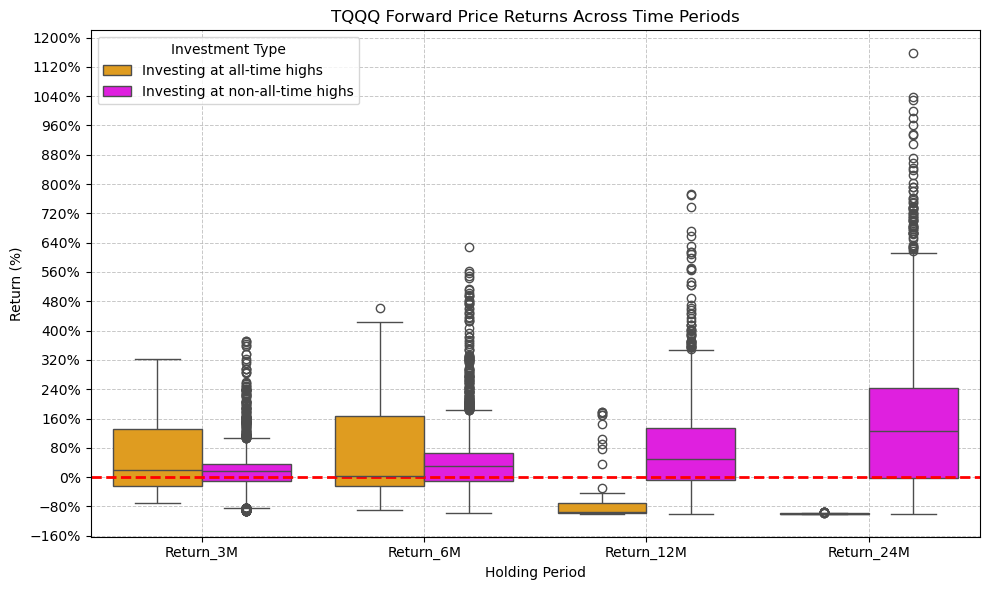

In [64]:
# Add group flag
ath_returns_df['Group'] = 'Investing at all-time highs'
non_ath_returns_df['Group'] = 'Investing at non-all-time highs'
# Join the two df's
combined_df = pd.concat([ath_returns_df, non_ath_returns_df])

# Melt DataFrame for the two groups & their holding periods
melted_df = combined_df.melt(
    id_vars=['Group'], 
    value_vars=['Return_3M', 'Return_6M', 'Return_12M', 'Return_24M'],#, 'Return_48M'], 
    var_name='Holding Period', 
    value_name='Return'
)

# Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=melted_df, 
    x='Holding Period', 
    y='Return', 
    hue='Group', 
    palette=['orange', 'magenta']
)

from matplotlib.ticker import PercentFormatter, MaxNLocator
plt.title('TQQQ Forward Price Returns Across Time Periods')
plt.xlabel('Holding Period')
plt.ylabel('Return (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # y-axis as percentages
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=20))  # Add more ticks on the y-axis
plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7) # Add a grid
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Add a baseline for 0% return
plt.legend(title='Investment Type')
plt.tight_layout()
plt.show()


#### Returns of TQQQ: Purchased on an All-Time High +-W Days vs. Any Other Day

Similarly, as mentioned above, we can examine the spread across multiple windows.

In [65]:
windows = [0,5,15,30,50,75]
for w in windows:
    print('------------------------------------------------------------------------------------')
    print(f"Window Size: {w} days")
    # Usage for "Adj Close" (baseline) and "Simulated Leveraged Price" (leveraged)
    ath_indices_leveraged = find_ath_indices(data, 'Simulated Leveraged Price', window=w) # window=30 adds +- 30 days

    # ATH returns
    print('\t\tInvesting at all-time highs:')
    ath_returns_df = calculate_ath_returns_all_periods(data, ath_indices_leveraged)
    print(ath_returns_df.iloc[:,2:].describe())

    print('------------------------------------------------------------------------------------')

    # Non-ATH returns
    print('\t\tInvesting at non-all-time highs:')
    non_ath_returns_df = calculate_non_ath_returns_all_periods(data, ath_indices_leveraged)
    print(non_ath_returns_df.iloc[:, 2:].describe())

------------------------------------------------------------------------------------
Window Size: 0 days
		Investing at all-time highs:
       Return_3M  Return_6M  Return_12M  Return_24M  Return_48M
count  58.000000  58.000000   58.000000   58.000000   58.000000
mean    0.558231   0.656923   -0.511773   -0.990256   -0.988850
std     1.027572   1.437781    0.881336    0.012936    0.005942
min    -0.698779  -0.903411   -0.994535   -0.999018   -0.996382
25%    -0.248415  -0.245643   -0.968091   -0.997564   -0.993901
50%     0.203497   0.033519   -0.944460   -0.997058   -0.989043
75%     1.311638   1.673437   -0.698391   -0.989451   -0.986459
max     3.214014   4.615067    1.787313   -0.958507   -0.973171
------------------------------------------------------------------------------------
		Investing at non-all-time highs:
         Return_3M    Return_6M   Return_12M   Return_24M   Return_48M
count  6361.000000  6270.000000  6087.000000  5722.000000  4992.000000
mean      0.134137     0.3

Once again we can visualize the descriptive statistics to better understand and interpret the distribution of returns.   
  
*Note that the Non-ATH Window is plotted only for `window=0`. This allows us to compare the returns at random points in time (Non-ATH) against the returns for all-time highs (ATH) across different windows.*

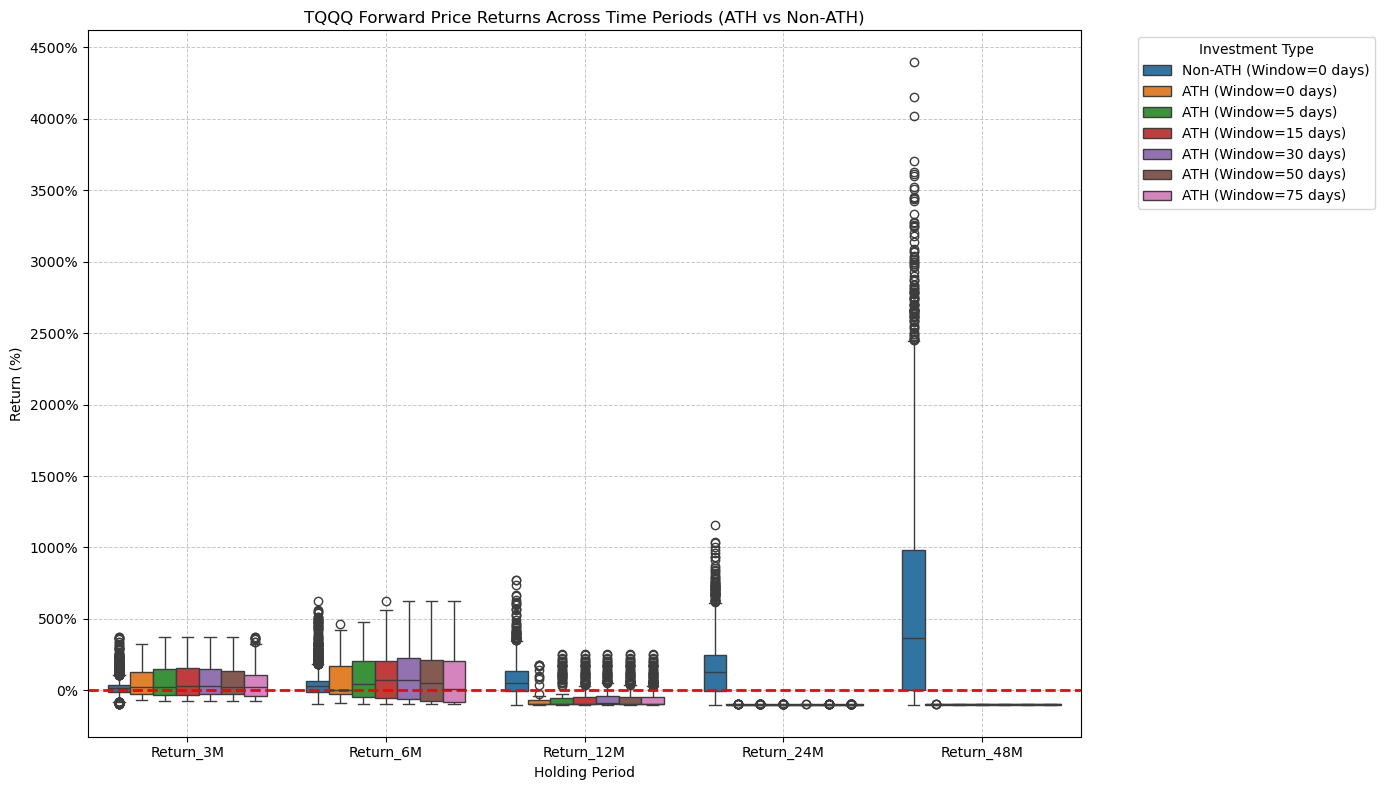

In [66]:
# Window sizes
windows = [0, 5, 15, 30, 50, 75]
combined_results = []
for w in windows:
    # Usage for "Adj Close" (baseline) and "Simulated Leveraged Price" (leveraged)
    ath_indices_leveraged = find_ath_indices(data, 'Simulated Leveraged Price', window=w)

    # ATH returns
    ath_returns_df = calculate_ath_returns_all_periods(data, ath_indices_leveraged)
    non_ath_returns_df = calculate_non_ath_returns_all_periods(data, ath_indices_leveraged)

    # Add group flag
    ath_returns_df['Group'] = f'ATH (Window={w} days)'
    if w == 0:
        non_ath_returns_df['Group'] = 'Non-ATH (Window=0 days)'
        combined_results.append(non_ath_returns_df)  # Only include non-ATH data for Window=0

    # Combine results
    combined_results.append(ath_returns_df)

# # Join to a single df
final_combined_df = pd.concat(combined_results)

# Melt DataFrame for the two groups & their holding periods
melted_df = final_combined_df.melt(
    id_vars=['Group'], 
    value_vars=['Return_3M', 'Return_6M', 'Return_12M', 'Return_24M', 'Return_48M'], 
    var_name='Holding Period', 
    value_name='Return'
)

# Create boxplots
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=melted_df, 
    x='Holding Period', 
    y='Return', 
    hue='Group', 
    palette='tab10'
)

# Customize plot aesthetics
plt.title('TQQQ Forward Price Returns Across Time Periods (ATH vs Non-ATH)')
plt.xlabel('Holding Period')
plt.ylabel('Return (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))  # y-axis as percentages
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))  # Add more ticks on the y-axis
plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)  # Add a grid
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Add a baseline for 0% return
plt.legend(title='Investment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
